<a href="https://colab.research.google.com/github/chakravartulavinay/self_projects/blob/main/Generative_University_Chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a id="2"></a>
## <b>2 <span style='color:#B21010'>||</span>Import Necessaries</b>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import json
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
import missingno as msno

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from keras.preprocessing import text
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk import word_tokenize
from nltk.stem import PorterStemmer

import torch
from torch.utils.data import Dataset

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import pipeline
from transformers import DistilBertTokenizerFast
from transformers import BertForSequenceClassification, BertTokenizerFast
from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizer, TFTrainingArguments
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
from transformers import TrainingArguments, Trainer

<a id="3"></a>
## <b>3 <span style='color:#B21010'>||</span> EDA + Vis</b>

<a id="3.1"></a>
### <b>3.1 <span style='color:#B21010'>||</span> Load the data</b>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_json_file(filename):
    with open(filename) as f:
        file = json.load(f)
    return file

filename = '/content/drive/MyDrive/Projects/Chatbot/intents.json'

intents = load_json_file(filename)

<a id="3.2"></a>
### <b>3.2 <span style='color:#B21010'>||</span> Extract Info from the Json data file and Store it in dataframe</b>

In [ ]:
def create_df():
    df = pd.DataFrame({
        'Pattern' : [],
        'Tag' : []
    })

    return df

df = create_df()
df

,Pattern,Tag


In [ ]:
def extract_json_info(json_file, df):

    for intent in json_file['intents']:

        for pattern in intent['patterns']:

            sentence_tag = [pattern, intent['tag']]
            df.loc[len(df.index)] = sentence_tag

    return df

df = extract_json_info(intents, df)
df.head()

,Pattern,Tag
0,Hi,greeting
1,How are you?,greeting
2,Is anyone there?,greeting
3,Hello,greeting
4,Good day,greeting


In [ ]:
df2 = df.copy()
df2.head()

,Pattern,Tag
0,Hi,greeting
1,How are you?,greeting
2,Is anyone there?,greeting
3,Hello,greeting
4,Good day,greeting


<a id="3.3"></a>
### <b>3.3 <span style='color:#B21010'>||</span> Check the shape of the dataset</b>

In [ ]:
def print_shape_df(df, ds_name="df"):
    print(f"{ds_name} dataset has {df.shape[0]} rows and {df.shape[1]} columns")

print_shape_df(df, "Chatbot")

Chatbot dataset has 405 rows and 2 columns


<a id="3.4"></a>
### <b>3.4 <span style='color:#B21010'>||</span> Display information about the dataset</b>

In [ ]:
def print_dfInfo(df, ds_name="df"):
    print(f"The info of {ds_name} dataset\n")
    print(df.info())

print_dfInfo(df, "Chatbot")

The info of Chatbot dataset

<class 'pandas.core.frame.DataFrame'>
Index: 405 entries, 0 to 404
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Pattern  405 non-null    object
 1   Tag      405 non-null    object
dtypes: object(2)
memory usage: 9.5+ KB
None


<a id="3.5"></a>
### <b>3.5 <span style='color:#B21010'>||</span> Display Number of Classes</b>

In [ ]:
def num_classes(df, target_col, ds_name="df"):
    print(f"The {ds_name} dataset has {len(df[target_col].unique())} classes")

num_classes(df, 'Tag', "Chatbot")

The Chatbot dataset has 38 classes


<a id="3.6"></a>
### <b>3.6 <span style='color:#B21010'>||</span> Check the null values in the dataset</b>

In [ ]:
def check_null(df, ds_name='df'):
    print(f"Null Values in each col in the {ds_name} dataset:\n")
    print(df.isnull().sum())

check_null(df, "Chatbot")

Null Values in each col in the Chatbot dataset:

Pattern    0
Tag        0
dtype: int64


<a id="3.7"></a>
### <b>3.7 <span style='color:#B21010'>||</span> Visualize the Null Values</b>

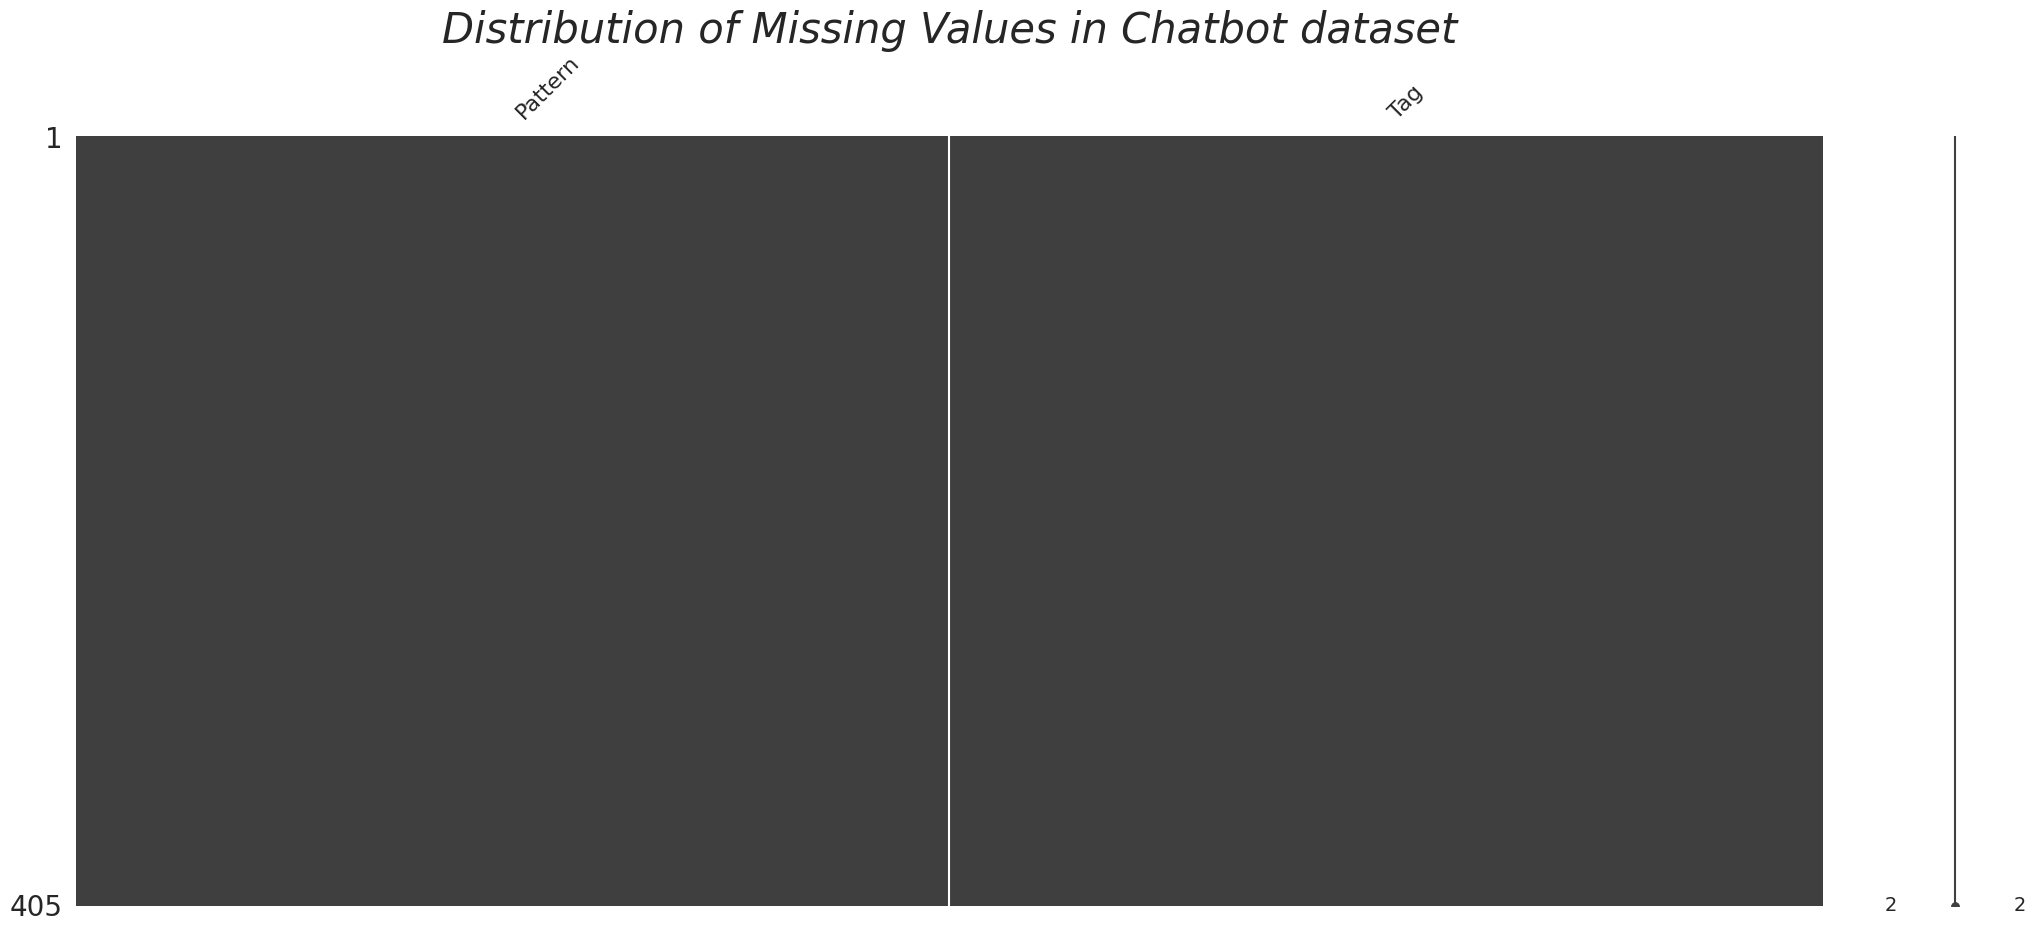

In [ ]:
def plot_miss_vals(df, ds_name="df"):
    msno.matrix(df)
    plt.title(f'Distribution of Missing Values in {ds_name} dataset', fontsize=30, fontstyle='oblique')
    plt.show()

plot_miss_vals(df, "Chatbot")

<a id="3.8"></a>
### <b>3.8 <span style='color:#B21010'>||</span> Visualize the distrbution of our Classes</b>

In [ ]:
def count_plot(x, df, title, xlabel, ylabel, width, height, order = None, rotation=False, palette='winter', hue=None):
    ncount = len(df)
    plt.figure(figsize=(width,height))
    ax = sns.countplot(x = x, palette=palette, order = order, hue=hue)
    plt.title(title, fontsize=20)
    if rotation:
        plt.xticks(rotation = 'vertical')
    plt.xlabel(xlabel, fontsize=25)
    plt.ylabel(ylabel, fontsize=25)

    ax.yaxis.set_label_position('left')
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y),
                ha='center', va='bottom') # set the alignment of the text

    plt.show()

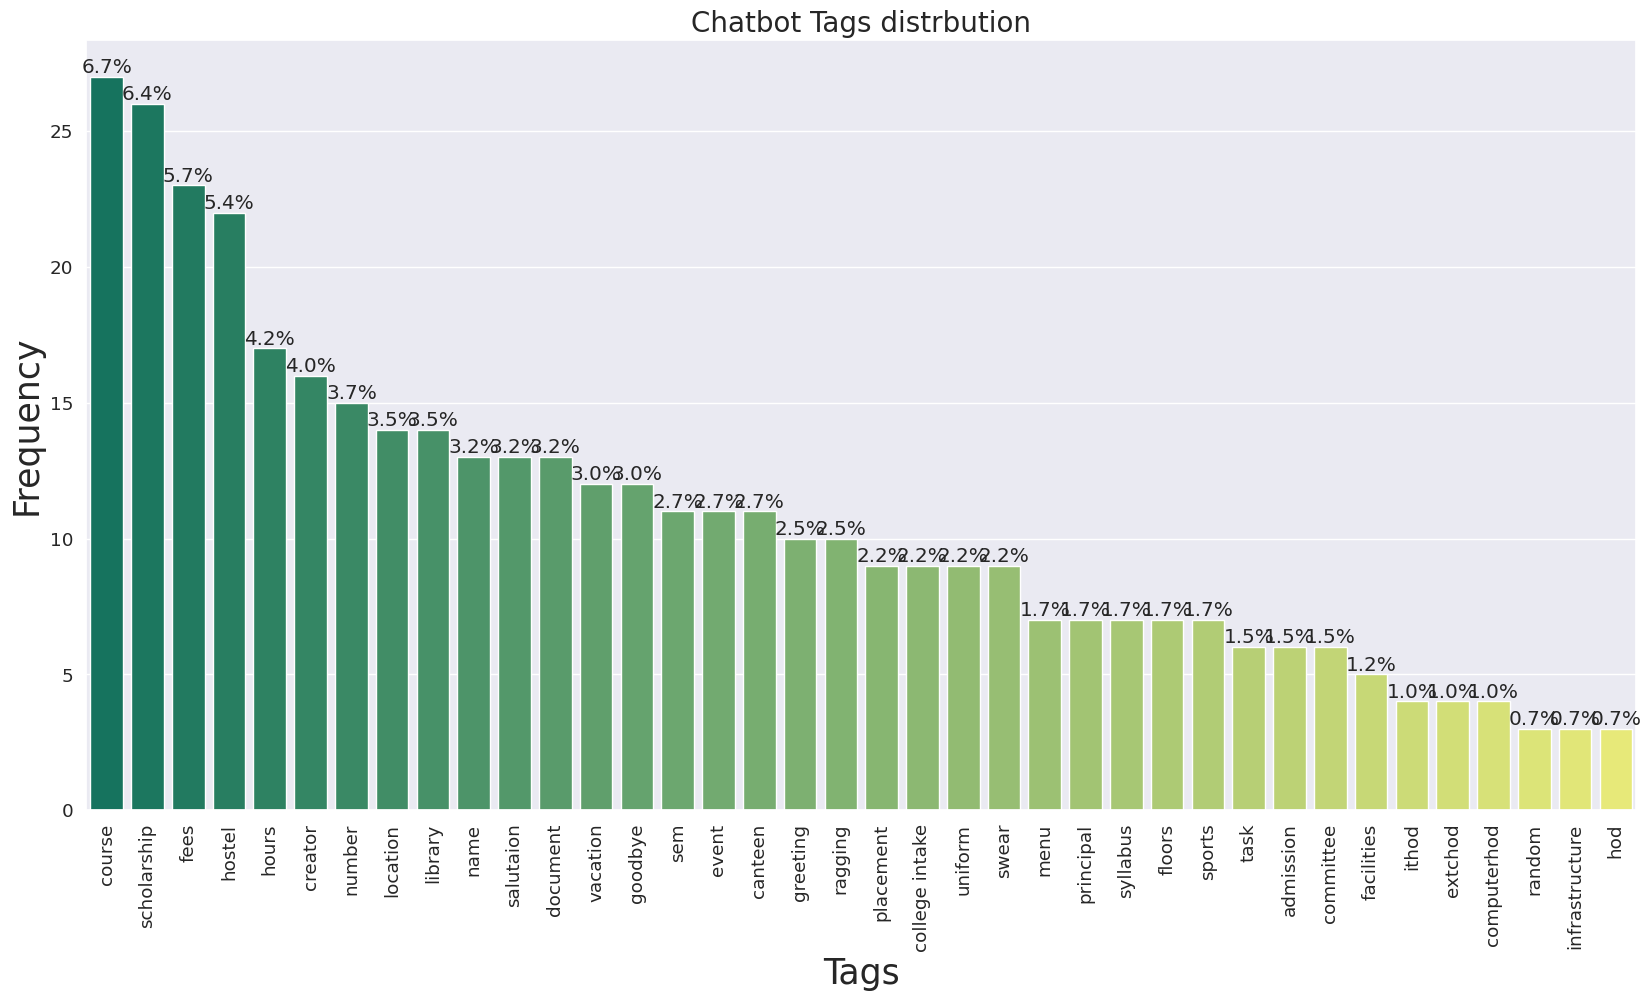

In [ ]:
sns.set(font_scale = 1.2)
order = df['Tag'].value_counts().index
count_plot(df['Tag'], df, "Chatbot Tags distrbution", "Tags", "Frequency", 20,10, order=order,rotation=True, palette="summer")

In [ ]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
stemmer = PorterStemmer()
ignore_words=['?', '!', ',', '.']

def preprocess_pattern(pattern):
    words = word_tokenize(pattern.lower())
    stemmed_words = [stemmer.stem(word) for word in words if word not in ignore_words]
    return " ".join(stemmed_words)

df['Pattern'] = df['Pattern'].apply(preprocess_pattern)

In [ ]:
df.head()

,Pattern,Tag
0,hi,greeting
1,how are you,greeting
2,is anyon there,greeting
3,hello,greeting
4,good day,greeting


In [ ]:
print(df['Pattern'].isnull().sum())

0


<a id="3.9"></a>
### <b>3.9 <span style='color:#B21010'>||</span> Display Word Cloud</b>

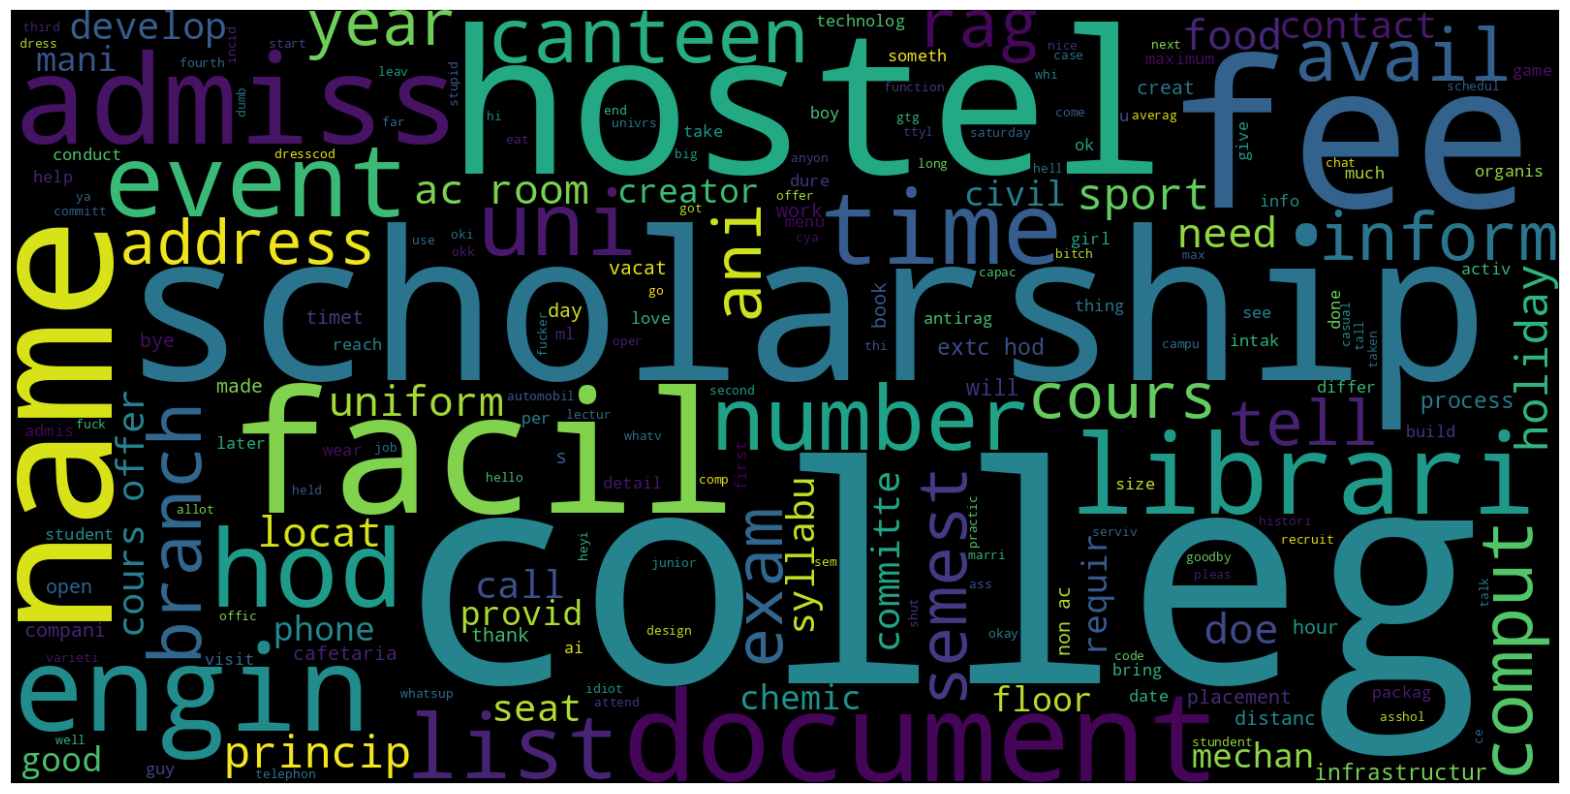

In [ ]:
plt.figure(figsize=(20, 20))
wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=STOPWORDS).generate(' '.join(df['Pattern']))
plt.imshow(wc, interpolation='bilinear')
plt.xticks([])
plt.yticks([])
plt.show()

<a id="3.10"></a>
### <b>3.10 <span style='color:#B21010'>||</span> Distrbution of Number of letters in each text</b>

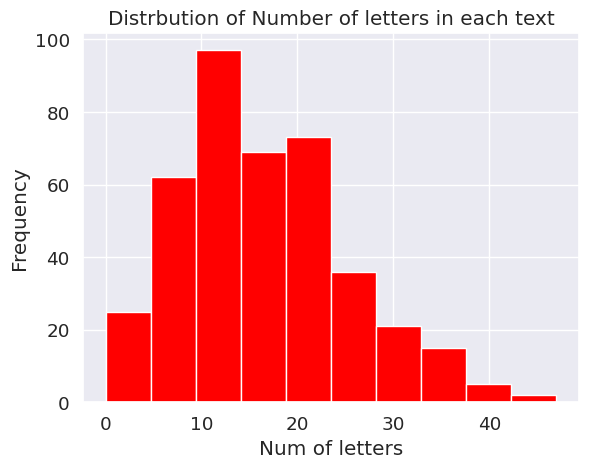

In [ ]:
letters_len=df['Pattern'].str.len()
plt.hist(letters_len,color='red')
plt.title("Distrbution of Number of letters in each text")
plt.xlabel("Num of letters")
plt.ylabel("Frequency")
plt.show()

<a id="3.11"></a>
### <b>3.11 <span style='color:#B21010'>||</span> Distrbution of Number of words in each text</b>

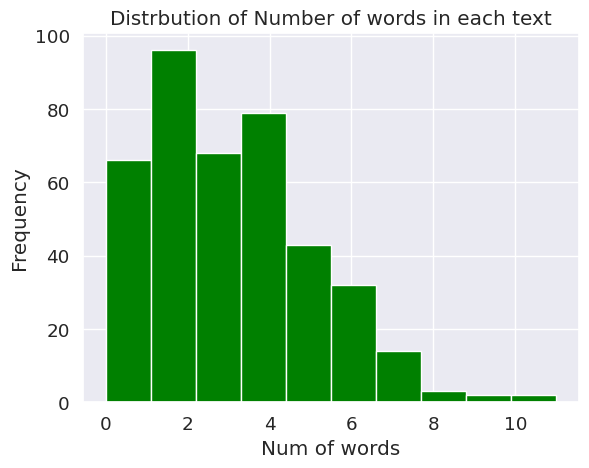

In [ ]:
words_len=df['Pattern'].str.split().map(lambda x: len(x))
plt.hist(words_len,color='green')
plt.title("Distrbution of Number of words in each text")
plt.xlabel("Num of words")
plt.ylabel("Frequency")
plt.show()

<a id="3.12"></a>
### <b>3.12 <span style='color:#B21010'>||</span> Visualize Average word length in each text</b>

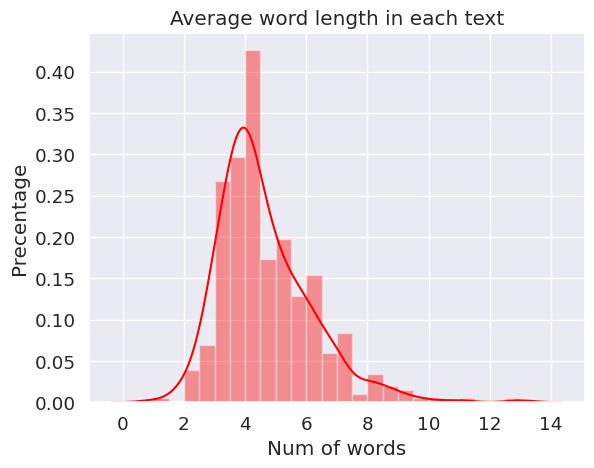

In [ ]:
word=df['Pattern'].str.split().apply(lambda x : [len(i) for i in x])
word = word.map(lambda x: np.mean(x))
sns.distplot(word,color='red')
plt.title("Average word length in each text")
plt.xlabel("Num of words")
plt.ylabel("Precentage")
plt.show()

<a id="3.13"></a>
### <b>3.13 <span style='color:#B21010'>||</span> Visualize top words</b>

In [ ]:
def get_corpus(series):
    words = []
    for text in series:
        for word in text.split():
            words.append(word.strip())
    return words

corpus = get_corpus(df.Pattern)
corpus[:5]

['hi', 'how', 'are', 'you', 'is']

In [ ]:
print(f"dataset contains {len(corpus)} words")

dataset contains 1345 words


In [ ]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'is': 75,
 'colleg': 71,
 'what': 59,
 'the': 46,
 'you': 35,
 'of': 33,
 'in': 29,
 'for': 26,
 'scholarship': 26,
 'are': 25}

In [ ]:
def get_top_text_ngrams(corpus, n,g):
    vec = CountVectorizer(ngram_range=(1, 1)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

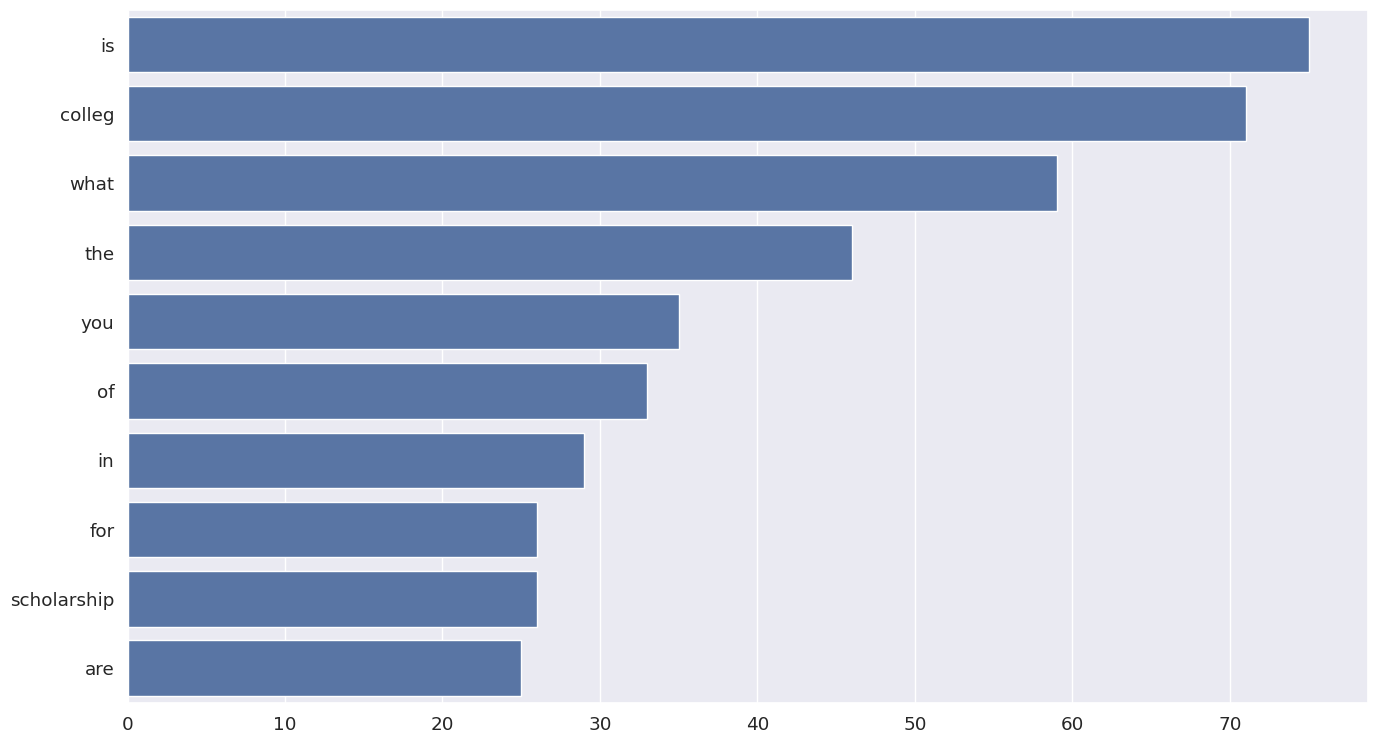

In [ ]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(df.Pattern,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()));

<a id="4"></a>
## <b>4 <span style='color:#B21010'>||</span> Data Preprocessing</b>

In [ ]:
df2.head()

,Pattern,Tag
0,Hi,greeting
1,How are you?,greeting
2,Is anyone there?,greeting
3,Hello,greeting
4,Good day,greeting


In [ ]:
labels = df2['Tag'].unique().tolist()
labels = [s.strip() for s in labels]
labels

['greeting',
 'goodbye',
 'creator',
 'name',
 'hours',
 'number',
 'course',
 'fees',
 'location',
 'hostel',
 'event',
 'document',
 'floors',
 'syllabus',
 'library',
 'infrastructure',
 'canteen',
 'menu',
 'placement',
 'ithod',
 'computerhod',
 'extchod',
 'principal',
 'sem',
 'admission',
 'scholarship',
 'facilities',
 'college intake',
 'uniform',
 'committee',
 'random',
 'swear',
 'vacation',
 'sports',
 'salutaion',
 'task',
 'ragging',
 'hod']

In [ ]:
num_labels = len(labels)
id2label = {id:label for id, label in enumerate(labels)}
label2id = {label:id for id, label in enumerate(labels)}

In [ ]:
id2label

{0: 'greeting',
 1: 'goodbye',
 2: 'creator',
 3: 'name',
 4: 'hours',
 5: 'number',
 6: 'course',
 7: 'fees',
 8: 'location',
 9: 'hostel',
 10: 'event',
 11: 'document',
 12: 'floors',
 13: 'syllabus',
 14: 'library',
 15: 'infrastructure',
 16: 'canteen',
 17: 'menu',
 18: 'placement',
 19: 'ithod',
 20: 'computerhod',
 21: 'extchod',
 22: 'principal',
 23: 'sem',
 24: 'admission',
 25: 'scholarship',
 26: 'facilities',
 27: 'college intake',
 28: 'uniform',
 29: 'committee',
 30: 'random',
 31: 'swear',
 32: 'vacation',
 33: 'sports',
 34: 'salutaion',
 35: 'task',
 36: 'ragging',
 37: 'hod'}

In [ ]:
label2id

{'greeting': 0,
 'goodbye': 1,
 'creator': 2,
 'name': 3,
 'hours': 4,
 'number': 5,
 'course': 6,
 'fees': 7,
 'location': 8,
 'hostel': 9,
 'event': 10,
 'document': 11,
 'floors': 12,
 'syllabus': 13,
 'library': 14,
 'infrastructure': 15,
 'canteen': 16,
 'menu': 17,
 'placement': 18,
 'ithod': 19,
 'computerhod': 20,
 'extchod': 21,
 'principal': 22,
 'sem': 23,
 'admission': 24,
 'scholarship': 25,
 'facilities': 26,
 'college intake': 27,
 'uniform': 28,
 'committee': 29,
 'random': 30,
 'swear': 31,
 'vacation': 32,
 'sports': 33,
 'salutaion': 34,
 'task': 35,
 'ragging': 36,
 'hod': 37}

In [ ]:
df2['labels'] = df2['Tag'].map(lambda x: label2id[x.strip()])
df2.head()

,Pattern,Tag,labels
0,Hi,greeting,0
1,How are you?,greeting,0
2,Is anyone there?,greeting,0
3,Hello,greeting,0
4,Good day,greeting,0


<a id="5"></a>
## <b>5 <span style='color:#B21010'>||</span> Split the data into train and test</b>

In [ ]:
X = list(df2['Pattern'])
X[:5]

['Hi', 'How are you?', 'Is anyone there?', 'Hello', 'Good day']

In [ ]:
y = list(df2['labels'])
y[:5]

[0, 0, 0, 0, 0]

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 123)

<a id="6"></a>
## <b>6 <span style='color:#B21010'>||</span> Load BERT Pretrained model and Tokenizer</b>

In [ ]:
model_name = "bert-base-uncased"
max_len = 256

tokenizer = BertTokenizer.from_pretrained(model_name,
                                          max_length=max_len)

model = BertForSequenceClassification.from_pretrained(model_name,
                                                      num_labels=num_labels,
                                                      id2label=id2label,
                                                      label2id = label2id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<a id="7"></a>
## <b>7 <span style='color:#B21010'>||</span> Transform the data into numerical format</b>

In [ ]:
train_encoding = tokenizer(X_train, truncation=True, padding=True)
test_encoding = tokenizer(X_test, truncation=True, padding=True)

In [ ]:
full_data = tokenizer(X, truncation=True, padding=True)

<a id="8"></a>
## <b>8 <span style='color:#B21010'>||</span> Build Data Loader</b>


In [ ]:
class DataLoader(Dataset):

    def __init__(self, encodings, labels):

        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):

        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):

        return len(self.labels)

In [ ]:
train_dataloader = DataLoader(train_encoding, y_train)
test_dataloader = DataLoader(test_encoding, y_test)

In [ ]:
fullDataLoader = DataLoader(full_data, y_test)

<a id="9"></a>
## <b>9 <span style='color:#B21010'>||</span> Define Evaluation Metrcies</b>


In [ ]:
def compute_metrics(pred):

    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)

    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

<a id="10"></a>
## <b>10 <span style='color:#B21010'>||</span> Define Training Arguments</b>


In [ ]:
# !pip uninstall transformers accelerate -y

In [ ]:
!pip install transformers[torch] accelerate -U

In [ ]:
from transformers import TrainingArguments

In [ ]:
training_args = TrainingArguments(
    output_dir='./output',
    do_train=True,
    do_eval=True,
    num_train_epochs=100,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.05,
    logging_strategy='steps',
    logging_dir='./multi-class-logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    load_best_model_at_end=True
)

<a id="11"></a>
## <b>11 <span style='color:#B21010'>||</span> Train the model</b>


In [ ]:
from transformers import Trainer, TFDistilBertForSequenceClassification, DistilBertTokenizer


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=test_dataloader,
    compute_metrics= compute_metrics
)

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,3.543600,3.343506,0.176471,0.081061,0.107307,0.122917
100,2.691700,2.281264,0.539216,0.447596,0.469200,0.520685
150,1.180400,1.041763,0.833333,0.772414,0.811953,0.785354
200,0.374100,0.566529,0.901961,0.894021,0.914062,0.896875
250,0.129500,0.489245,0.901961,0.879674,0.901042,0.896875
300,0.061400,0.433498,0.911765,0.912531,0.930108,0.932258
350,0.045100,0.470512,0.911765,0.912531,0.930108,0.932258
400,0.030500,0.465610,0.911765,0.912531,0.930108,0.932258
450,0.026500,0.463491,0.911765,0.910918,0.922581,0.932258
500,0.023700,0.460239,0.911765,0.910918,0.922581,0.932258


TrainOutput(global_step=1000, training_loss=0.4127698670625687, metrics={'train_runtime': 173.7047, 'train_samples_per_second': 174.434, 'train_steps_per_second': 5.757, 'total_flos': 264789670748400.0, 'train_loss': 0.4127698670625687, 'epoch': 100.0})

<a id="12"></a>
## <b>12 <span style='color:#B21010'>||</span> Evaluate the model</b>


In [ ]:
q=[trainer.evaluate(eval_dataset=df2) for df2 in [train_dataloader, test_dataloader]]

pd.DataFrame(q, index=["train","test"]).iloc[:,:5]

,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.015561,0.996700,0.998509,0.998747,0.998355
test,0.460239,0.911765,0.910918,0.922581,0.932258


In [ ]:
def predict(text):
    # Move model to the correct device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Tokenize the input text and move it to the correct device
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to(device)

    # Get model outputs
    outputs = model(**inputs)

    # Calculate probabilities and get the predicted label index
    probs = outputs[0].softmax(1)
    pred_label_idx = probs.argmax()
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label

In [ ]:
text = "Hello"
predict(text)

(tensor([[9.9040e-01, 3.3191e-04, 1.2267e-04, 7.4575e-04, 1.9305e-04, 1.5526e-04,
          1.7677e-04, 2.2662e-04, 4.9142e-04, 1.9238e-04, 4.0923e-05, 9.3093e-05,
          1.5693e-04, 1.2055e-04, 2.0524e-04, 2.4427e-04, 2.1920e-04, 1.8351e-04,
          4.1057e-04, 1.3971e-04, 1.2467e-04, 3.1197e-04, 4.1179e-04, 1.7561e-04,
          2.3075e-04, 2.2684e-04, 1.2891e-04, 3.1650e-04, 3.6513e-04, 4.0976e-04,
          3.1265e-04, 3.0021e-04, 6.5169e-05, 1.1836e-04, 5.2876e-04, 5.7674e-04,
          2.3661e-04, 3.1473e-04]], device='cuda:0', grad_fn=<SoftmaxBackward0>),
 tensor(0, device='cuda:0'),
 'greeting')

<a id="13"></a>
## <b>13 <span style='color:#B21010'>||</span> Save the model</b>


In [ ]:
model_path = "chatbot"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('chatbot/tokenizer_config.json',
 'chatbot/special_tokens_map.json',
 'chatbot/vocab.txt',
 'chatbot/added_tokens.json')

In [ ]:
!pip install xformers

<a id="14"></a>
## <b>14 <span style='color:#B21010'>||</span> Load the model</b>


In [ ]:
model_path = "/content/chatbot"


model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer= BertTokenizerFast.from_pretrained(model_path)
chatbot= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
chatbot("Hello")

[{'label': 'greeting', 'score': 0.9903950095176697}]

<a id="15"></a>
## <b>15 <span style='color:#B21010'>||</span> Chat with the Chatbot</b>


In [ ]:
def chat(chatbot):

    print("Chatbot: Hi! I am your virtual assistance,Feel free to ask, and I'll do my best to provide you with answers and assistance..")
    print("Type 'quit' to exit the chat\n\n")

    text = input("User: ").strip().lower()

    while(text != 'quit'):

        score = chatbot(text)[0]['score']

        if score < 0.8:
            print("Chatbot: Sorry I can't answer that\n\n")
            text = input("User: ").strip().lower()
            continue

        label = label2id[chatbot(text)[0]['label']]
        response = random.choice(intents['intents'][label]['responses'])

        print(f"Chatbot: {response}\n\n")

        text = input("User: ").strip().lower()


In [ ]:
chat(chatbot)

Chatbot: Hi! I am your virtual assistance,Feel free to ask, and I'll do my best to provide you with answers and assistance..
Type 'quit' to exit the chat


User: hii
Chatbot: Hi there, how can I help?


User: how are you??
Chatbot: Hello!


User: had your lunch??
Chatbot: we serve Franky, Locho, Alu-puri, Kachori, Khavsa, Thaali and many more on menu


User: what your doing??
Chatbot: Hi there, how can I help?


User: fees
Chatbot: For Fee detail visit <a target="_blank" href="LINK"> here</a>


User: college students?
Chatbot: Sorry I can't answer that


User: any friends?
Chatbot: Sorry I can't answer that


User: okay
Chatbot: I am glad I helped you


User: what can you help with?
Chatbot: I can answer to low-intermediate questions regarding college


User: thats fine 
Chatbot: I am glad I helped you


User: give me something you know
Chatbot: I can answer to low-intermediate questions regarding college


User: bye
Chatbot: Sad to see you go :(


User: quit
